### Code Hist.

 - CODE  
    &ensp; : Model - KIER Method 02(Clustering)

  - DATE      &ensp; 2023-03-05 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) Dataset : KIER / KMA_ASOS    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) Model : LightGBM  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [544]:
#region Basic_Import
## Basic
import os, sys, warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.path.dirname(os.path.abspath('./__file__'))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('./__file__'))))
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from pandas import DataFrame, Series
pd.options.display.float_format = '{:.10f}'.format

import math, random

## Datetime
import time, datetime as dt
from datetime import datetime, date, timedelta

## glob
import glob, requests, json
from glob import glob

## 시각화
import matplotlib.pyplot as plt, seaborn as sns
# %matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## Split, 정규화
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans

# Clustering 알고리즘의 성능 평가 측도
from sklearn import metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## For Web
import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import tqdm
from tqdm.notebook import tqdm
#endregion Basic_Import

In [545]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch, torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf, tensorflow_addons as tfa
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.models import Sequential, load_model
    from keras_flops import get_flops
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [546]:
## LSTM
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [547]:
## Import_Local
from Src_Dev_Common import Data_Datetime as com_date, KMA_Weather as com_KMA, KECO_AirKor as com_KECO, KASI_Holiday as com_Holi, KIER_Usage_M02 as com_KIER_M02, Data_Clustering as com_clustering, Data_Analysis as com_Analysis, Common_Model as com_Model

### 01-01-02. Config (Directory, Params)

In [548]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"], os.environ['TF_DETERMINISTIC_OPS'] = str(SEED), "1"

In [549]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y, str_now_m, str_now_d = pd.datetime.now().year, pd.datetime.now().month, pd.datetime.now().day
str_now_hr, str_now_min = pd.datetime.now().hour, pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-08-11 02:39:32.895770
2024 / 8 / 11
2 : 39


In [550]:
## Dict_Domain
## {0:"ELEC", 1:"HEAT", 2:"WATER", 3:"HOT_HEAT", 4:"HOT_FLOW", 99:"GAS"}
## {0 : '10MIN', 1 : '30MIN', 2 : '1H', 3 : '12H', 4 : '1D', 5 : '1W', 6 : '2W', 7 : '1M'}
int_domain, int_interval, K = 0, 6, 2

## Domain, ACCU/INST Column
str_domain, str_col_accu, str_col_inst = com_KIER_M02.create_domain_str(int_domain)
## Directory Root
str_dirData, str_dir_raw, str_dir_cleansed, str_dirName_bld, str_dirName_h = com_KIER_M02.create_dir_str(str_domain)
## Interval, Target File
str_interval, str_fileRaw, str_fileRaw_hList, str_file = com_KIER_M02.create_file_str(str_domain, int_interval)

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

0 : ELEC
str_fileRaw : KIER_RAW_ELEC_2024-06-07.csv
str_fileRaw_hList : KIER_RAW_ELEC_2024-06-07.csv
str_file : KIER_ELEC_INST_2W_Resampled.csv
['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'DATE_1M_2023-10-20.csv', 'KIER 전처리 현황_2024-06-25.xlsx', 'KIER_0_Raw', 'KIER_1_Cleansed', 'KIER_2_BLD', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_DATA_OLD', 'KIER_ETC', 'KIER_hList_Comparison_2024-06-26.xlsx', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', '[IITP] 데이터 테이블 정리 (공유 원본).docx']

['KIER_ELEC_561-1-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-4_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-

## 01-02. Data Load (df_raw)

### 01-02-01. KMA ASOS

In [551]:
## KMA_ASOS Data
# str_dir_kmaAsos = "../data/data_KMA_ASOS/"

## Interpolate / Filled ASOS Data
str_file = '../data_Energy_KIER/KMA_ASOS_119_2010_2023_1st_to CSV.csv'
df_ASOS = pd.read_csv(str_file, index_col = 0).reset_index()

try : df_ASOS['METER_DATE'] = pd.to_datetime(df_ASOS['METER_DATE'])
except KeyError : df_kier_raw = com_date.create_col_datetime(df_ASOS, 'METER_DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE').drop(labels = ['None'], axis = 1)

df_ASOS

,METER_DATE,YEAR,MONTH,DAY,HOUR,MINUTE,temp_outdoor,temp_dew_point,temp_ground,humidity,...,wind_speed,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range
0,2010-01-01 00:00:00,2010,1,1,0,0,-10.3000000000,-17.6000000000,-5.8000000000,55.0000000000,...,1.6000000000,340.0000000000,1.5000000000,1019.7000000000,1024.3000000000,NaN,NaN,0.0000000000,0.0000000000,2000.0000000000
1,2010-01-01 01:00:00,2010,1,1,1,0,-10.4000000000,-17.9000000000,-5.7000000000,54.0000000000,...,0.3000000000,0.0000000000,1.5000000000,1019.5000000000,1024.1000000000,NaN,NaN,NaN,NaN,NaN
2,2010-01-01 02:00:00,2010,1,1,2,0,-10.6000000000,-17.6000000000,-5.9000000000,56.0000000000,...,0.6000000000,270.0000000000,1.5000000000,1019.7000000000,1024.3000000000,NaN,NaN,NaN,NaN,NaN
3,2010-01-01 03:00:00,2010,1,1,3,0,-11.0000000000,-18.0000000000,-5.9000000000,56.0000000000,...,1.5000000000,290.0000000000,1.5000000000,1019.7000000000,1024.3000000000,NaN,NaN,0.0000000000,0.0000000000,2000.0000000000
4,2010-01-01 04:00:00,2010,1,1,4,0,-11.6000000000,-18.2000000000,-6.0000000000,58.0000000000,...,0.9000000000,290.0000000000,1.5000000000,1019.4000000000,1024.0000000000,NaN,NaN,0.0000000000,0.0000000000,2000.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116911,2023-10-17 19:00:00,2023,10,17,19,0,14.4000000000,4.9000000000,14.7000000000,53.0000000000,...,0.4000000000,0.0000000000,8.7000000000,1015.1000000000,1019.9000000000,NaN,NaN,0.0000000000,0.0000000000,5000.0000000000
116912,2023-10-17 20:00:00,2023,10,17,20,0,12.5000000000,5.8000000000,13.4000000000,64.0000000000,...,0.3000000000,0.0000000000,9.2000000000,1015.6000000000,1020.4000000000,NaN,NaN,0.0000000000,0.0000000000,3742.0000000000
116913,2023-10-17 21:00:00,2023,10,17,21,0,11.4000000000,6.5000000000,12.4000000000,72.0000000000,...,0.8000000000,320.0000000000,9.7000000000,1015.8000000000,1020.6000000000,NaN,NaN,0.0000000000,0.0000000000,3158.0000000000
116914,2023-10-17 22:00:00,2023,10,17,22,0,10.2000000000,6.8000000000,11.5000000000,80.0000000000,...,0.8000000000,320.0000000000,9.9000000000,1016.2000000000,1021.1000000000,NaN,NaN,0.0000000000,0.0000000000,3321.0000000000


In [552]:
## Cluster 기준 Interval
str_file_clustering = 'KIER_' + str(str_domain) + '_Labeled_' + str_interval + '_K' + str(K) + '.csv'
df_kier_h_cluster = pd.read_csv(str_dirName_h + str_file_clustering
                                , index_col = 0).rename(columns = {'index' : 'h_index'})[['h_index', 'target_' + str_domain]]
print(str_interval)
print(df_kier_h_cluster['target_' + str_domain].drop_duplicates())
df_kier_h_cluster

2W
0    0
1    1
Name: target_ELEC, dtype: int64


,h_index,target_ELEC
0,ELEC_INST_EFF_561-2-2,0
1,ELEC_INST_EFF_561-2-3,1
2,ELEC_INST_EFF_561-2-4,0
3,ELEC_INST_EFF_561-3-1,1
4,ELEC_INST_EFF_561-3-2,0
...,...,...
336,ELEC_INST_EFF_563-22-6,0
337,ELEC_INST_EFF_563-23-1,0
338,ELEC_INST_EFF_563-23-2,1
339,ELEC_INST_EFF_563-23-3,0


In [553]:
list_kier_h_all = df_kier_h_cluster['h_index']
print(len(list_kier_h_all))
list_kier_h_c0 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 0]['h_index']
print(len(list_kier_h_c0))
list_kier_h_c1 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 1]['h_index']
print(len(list_kier_h_c1))
list_kier_h_c2 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 2]['h_index']
print(len(list_kier_h_c2))

341
200
141
0


In [554]:
## 사용량 Data Load
## 1시간 단위
str_file = 'KIER_' + str_domain + '_INST_1H_Resampled.csv'
df_raw = pd.read_csv(str_dirName_h + str_file, index_col = 0)
df_raw

,METER_DATE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-1,...,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2
0,2022-07-17 23:00:00,0.8600000000,1.2500000000,0.1700000000,1.0633876812,0.8600000000,0.2500000000,0.6000000000,0.4800000000,0.8100000000,...,0.6000000000,0.6100000000,0.1900000000,0.2200000000,0.2200000000,0.3600000000,0.2600000000,0.2100000000,0.1600000000,0.4400000000
1,2022-07-18 00:00:00,0.7277880265,1.1200000000,0.1800000000,0.9600000000,0.4500000000,0.2600000000,0.6000000000,0.4600000000,0.7100000000,...,0.2349605523,0.4600000000,0.1600000000,0.2400000000,0.3100000000,0.4100000000,0.2500000000,0.2000000000,0.1400000000,0.3868823529
2,2022-07-18 01:00:00,0.5011737005,0.9900000000,0.1900000000,0.8900000000,0.5800000000,0.2400000000,0.6300000000,0.4500000000,0.7000000000,...,0.2100000000,0.2700000000,0.1600000000,0.2700000000,0.2500000000,0.3400000000,0.2600000000,0.2000000000,0.1300000000,0.2500000000
3,2022-07-18 02:00:00,0.3300000000,1.0300000000,0.2000000000,1.0600000000,0.2700000000,0.1800000000,0.1400000000,0.2700000000,0.6100000000,...,0.2000000000,0.2500000000,0.1400000000,0.2400000000,0.2100000000,0.3400000000,0.2600000000,0.1900000000,0.1400000000,0.2200000000
4,2022-07-18 03:00:00,0.2600000000,1.0000000000,0.2700000000,0.8700000000,0.6200000000,0.1700000000,0.1300000000,0.2300000000,0.5700000000,...,0.2100000000,0.2800000000,0.1300000000,0.3200000000,0.1900000000,0.4600000000,0.2800000000,0.1800000000,0.1800000000,0.3000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16523,2024-06-05 10:00:00,0.3600000000,0.6900000000,0.3200000000,0.3000000000,0.6400000000,0.3200000000,0.2900000000,0.4400000000,0.3800000000,...,0.1900000000,0.3100000000,0.5000000000,0.2500000000,0.1500000000,0.2500000000,0.1700000000,0.4200000000,0.2100000000,0.2400000000
16524,2024-06-05 11:00:00,0.2700000000,0.4953636364,0.3300000000,0.2100000000,0.4353636364,0.2253636364,0.2053636364,0.5653636364,0.1900000000,...,0.1753636364,0.2353636364,0.3453636364,0.1600000000,0.3453636364,0.3100000000,0.1953636364,0.2053636364,0.2453636364,0.2353636364
16525,2024-06-05 12:00:00,0.2900000000,0.7800000000,0.4000000000,0.2300000000,0.5100000000,0.1800000000,0.1900000000,0.7200000000,0.5900000000,...,0.1800000000,0.1800000000,0.3000000000,0.2000000000,0.4100000000,0.4400000000,0.1800000000,0.1800000000,0.2100000000,0.1900000000
16526,2024-06-05 13:00:00,0.3200000000,0.3900000000,1.0900000000,0.2278662554,0.5000000000,0.1700000000,0.1700000000,0.3078662554,0.3578662554,...,0.2567782655,0.2683431510,0.2200000000,0.3055204052,0.1500000000,0.3467782655,0.2472003185,0.3167782655,0.3367782655,0.2667782655


In [555]:
## 1) Target 추가 : Cluster별 사용량 합계
## 2) 입력변수 추가 : 각 세대별 1시간 이전 사용량
## ■ 전체 사용량 합계
df_kier_h_all = df_raw.copy()
df_kier_h_all['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
df_kier_h_tmp = df_raw[list_kier_h_all]
df_kier_h_all[str_domain + '_INST_SUM_ALL'] = df_kier_h_tmp.sum(axis = 1)
## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
df_kier_h_all[str_domain + '_INST_SUM_ALL'] = df_kier_h_all[str_domain + '_INST_SUM_ALL'].shift(1)
df_kier_h_all.dropna()
df_kier_h_all = df_kier_h_all.dropna()

## ■ C00
df_kier_h_c0 = df_raw.copy()[list_kier_h_c0]
df_kier_h_c0['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
df_kier_h_tmp = df_raw[list_kier_h_c0]
df_kier_h_c0[str_domain + '_INST_SUM_C0'] = df_kier_h_tmp.sum(axis = 1)
## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
df_kier_h_c0[str_domain + '_INST_SUM_C0'] = df_kier_h_c0[str_domain + '_INST_SUM_C0'].shift(1)
df_kier_h_c0 = df_kier_h_c0.dropna()

## ■ C01
df_kier_h_c1 = df_raw.copy()[list_kier_h_c1]
df_kier_h_c1['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
df_kier_h_tmp = df_raw[list_kier_h_c1]
df_kier_h_c1[str_domain + '_INST_SUM_C1'] = df_kier_h_tmp.sum(axis = 1)
## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
df_kier_h_c1[str_domain + '_INST_SUM_C1'] = df_kier_h_c1[str_domain + '_INST_SUM_C1'].shift(1)
df_kier_h_c1 = df_kier_h_c1.dropna()

if K == 3 : 
    ## ■ C02
    df_kier_h_c2 = df_raw.copy()[list_kier_h_c2]
    df_kier_h_c2['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
    df_kier_h_tmp = df_raw[list_kier_h_c2]
    df_kier_h_c2[str_domain + '_INST_SUM_C2'] = df_kier_h_tmp.sum(axis = 1)
    ## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
    df_kier_h_c2[str_domain + '_INST_SUM_C2'] = df_kier_h_c2[str_domain + '_INST_SUM_C2'].shift(1)
    df_kier_h_c2 = df_kier_h_c2.dropna()

In [556]:
df_kier_h_c0

,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-2,ELEC_INST_EFF_561-3-3,ELEC_INST_EFF_561-4-1,ELEC_INST_EFF_561-4-4,ELEC_INST_EFF_561-5-2,ELEC_INST_EFF_561-6-2,ELEC_INST_EFF_561-6-3,ELEC_INST_EFF_561-7-3,...,ELEC_INST_EFF_563-21-5,ELEC_INST_EFF_563-22-2,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,METER_DATE,ELEC_INST_SUM_C0
1,0.2600000000,0.4600000000,0.4000000000,0.2000000000,0.3300000000,0.5500000000,0.1700000000,0.3000000000,0.1600000000,0.3900000000,...,0.2000000000,0.3300000000,0.2349605523,0.4600000000,0.2400000000,0.3100000000,0.2500000000,0.2000000000,2022-07-18 00:00:00,62.1168843656
2,0.2400000000,0.4500000000,0.2900000000,0.2100000000,0.3400000000,0.2200000000,0.1300000000,0.2900000000,0.1800000000,0.3000000000,...,0.2100000000,0.2700000000,0.2100000000,0.2700000000,0.2700000000,0.2500000000,0.2600000000,0.2000000000,2022-07-18 01:00:00,52.0485172294
3,0.1800000000,0.2700000000,0.4000000000,0.2100000000,0.3500000000,0.2200000000,0.1400000000,0.3300000000,0.1800000000,0.2000000000,...,0.1800000000,0.1300000000,0.2000000000,0.2500000000,0.2400000000,0.2100000000,0.2600000000,0.1900000000,2022-07-18 02:00:00,46.9582293053
4,0.1700000000,0.2300000000,0.2800000000,0.2100000000,0.3000000000,0.2200000000,0.1300000000,0.2688986352,0.1600000000,0.1800000000,...,0.1900000000,0.1400000000,0.2100000000,0.2800000000,0.3200000000,0.1900000000,0.2800000000,0.1800000000,2022-07-18 03:00:00,44.8582322147
5,0.1800000000,0.2400000000,0.2800000000,0.1900000000,0.2200000000,0.2200000000,0.1100000000,0.2700000000,0.1800000000,0.3000000000,...,0.1900000000,0.1400000000,0.1900000000,0.2600000000,0.2500000000,0.2200000000,0.2500000000,0.1800000000,2022-07-18 04:00:00,43.4609088213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16523,0.3200000000,0.4400000000,0.5700000000,0.1800000000,0.2600000000,0.1400000000,1.2100000000,0.2200000000,0.3000000000,0.1400000000,...,0.2000000000,0.2800000000,0.1900000000,0.3100000000,0.2500000000,0.1500000000,0.1700000000,0.4200000000,2024-06-05 10:00:00,49.4881556196
16524,0.2253636364,0.5653636364,0.1300000000,0.2153636364,0.2453636364,0.1853636364,0.3753636364,0.1800000000,0.2900000000,0.2300000000,...,0.1200000000,0.3353636364,0.1753636364,0.2353636364,0.1600000000,0.3453636364,0.1953636364,0.2053636364,2024-06-05 11:00:00,55.8569452450
16525,0.1800000000,0.7200000000,0.2200000000,0.4000000000,0.3300000000,0.1400000000,0.3800000000,0.1400000000,0.3600000000,0.1600000000,...,0.1700000000,0.3200000000,0.1800000000,0.1800000000,0.2000000000,0.4100000000,0.1800000000,0.1800000000,2024-06-05 12:00:00,51.9886936416
16526,0.1700000000,0.3078662554,0.2200000000,0.4400000000,0.2300000000,0.1200000000,0.3400000000,0.1978662554,0.3078662554,0.1300000000,...,0.1400000000,0.3067782655,0.2567782655,0.2683431510,0.3055204052,0.1500000000,0.2472003185,0.3167782655,2024-06-05 13:00:00,52.1673980384


In [557]:
## 날씨 데이터 추가
df_kier_h_all = pd.merge(df_kier_h_all, df_ASOS, how = 'left', on = ['METER_DATE'])
df_kier_h_all = com_KMA.Interpolate_KMA_ASOS(df_kier_h_all)
df_kier_h_all = com_date.create_col_ymdhm(df_kier_h_all, 'METER_DATE')

df_kier_h_c0 = pd.merge(df_kier_h_c0, df_ASOS, how = 'left', on = ['METER_DATE'])
df_kier_h_c0 = com_KMA.Interpolate_KMA_ASOS(df_kier_h_c0)
df_kier_h_c0 = com_date.create_col_ymdhm(df_kier_h_c0, 'METER_DATE')

df_kier_h_c1 = pd.merge(df_kier_h_c1, df_ASOS, how = 'left', on = ['METER_DATE'])
df_kier_h_c1 = com_KMA.Interpolate_KMA_ASOS(df_kier_h_c1)
df_kier_h_c1 = com_date.create_col_ymdhm(df_kier_h_c1, 'METER_DATE')

if K == 3 : 
    df_kier_h_c2 = pd.merge(df_kier_h_c2, df_ASOS, how = 'left', on = ['METER_DATE'])
    df_kier_h_c2 = com_KMA.Interpolate_KMA_ASOS(df_kier_h_c2)
    df_kier_h_c2 = com_date.create_col_ymdhm(df_kier_h_c2, 'METER_DATE')

In [558]:
## 각 세대별 이전시간 사용량 컬럼을 제거하고 분석하는 경우
df_kier_h_all = df_kier_h_all.drop(labels = list_kier_h_all, axis = 1)
df_kier_h_c0 = df_kier_h_c0.drop(labels = list_kier_h_c0, axis = 1)
df_kier_h_c1 = df_kier_h_c1.drop(labels = list_kier_h_c1, axis = 1)
if K == 3 : df_kier_h_c2 = df_kier_h_c2.drop(labels = list_kier_h_c2, axis = 1)

In [559]:
# pd.set_option('display.max_row', 500)
print(df_kier_h_all.shape, ' /// ', df_kier_h_all.columns)
print(df_kier_h_all.isna().sum())
print(df_kier_h_c0.shape, ' /// ', df_kier_h_all.columns)
print(df_kier_h_c0.isna().sum())
print(df_kier_h_c1.shape, ' /// ', df_kier_h_all.columns)
print(df_kier_h_c1.isna().sum())

if K == 3 : 
    print(df_kier_h_c2.shape, ' /// ', df_kier_h_all.columns)
    print(df_kier_h_c2.isna().sum())

(16527, 31)  ///  Index(['METER_DATE', 'ELEC_INST_EFF_561-1-1', 'ELEC_INST_EFF_561-1-2',
       'ELEC_INST_EFF_561-1-3', 'ELEC_INST_EFF_561-1-4',
       'ELEC_INST_EFF_561-2-1', 'ELEC_INST_EFF_563-24-1',
       'ELEC_INST_EFF_563-24-2', 'ELEC_INST_SUM_ALL', 'YEAR', 'MONTH', 'DAY',
       'HOUR', 'MINUTE', 'temp_outdoor', 'temp_dew_point', 'temp_ground',
       'humidity', 'rainfall', 'snowfall', 'snowfall_3hr', 'wind_speed',
       'wind_direction', 'pressure_vapor', 'pressure_area', 'pressure_sea',
       'sunshine', 'solar_radiation', 'cloud_total', 'cloud_midlow',
       'visual_range'],
      dtype='object')
METER_DATE                0
ELEC_INST_EFF_561-1-1     0
ELEC_INST_EFF_561-1-2     0
ELEC_INST_EFF_561-1-3     0
ELEC_INST_EFF_561-1-4     0
ELEC_INST_EFF_561-2-1     0
ELEC_INST_EFF_563-24-1    0
ELEC_INST_EFF_563-24-2    0
ELEC_INST_SUM_ALL         0
YEAR                      0
MONTH                     0
DAY                       0
HOUR                      0
MINUTE          

## 01-06. Data Split (Train/Test Setting)

In [560]:
## 모든 세대
# df_raw = df_kier_h_all
# str_col_tar = str_domain + '_INST_SUM_ALL'
## C1 세대
# df_raw = df_kier_h_c0
# str_col_tar = str_domain + '_INST_SUM_C0'
## C2 세대
df_raw = df_kier_h_c1
str_col_tar = str_domain + '_INST_SUM_C1'
## C3 세대
# df_raw = df_kier_h_c2
# str_col_tar = str_domain + '_INST_SUM_C2'

# df_raw = com_date.create_col_ymdhm(df_raw, 'METER_DATE')
# df_raw = com_date.create_col_weekdays(df_raw, 'METER_DATE')
df_raw = df_raw.drop(columns = ['METER_DATE', 'DAY']).dropna()
# df_raw = df_raw.drop(columns = ['METER_DATE', 'day_of_the_week'])
# df_raw = df_raw.drop(columns = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'None']).dropna()

trainSet_Origin, testSet_Origin = train_test_split(df_raw, test_size=0.3, shuffle=False)
print(trainSet_Origin.shape, testSet_Origin.shape)

(11568, 22) (4959, 22)


In [561]:
trainSet = trainSet_Origin
testSet = testSet_Origin

## Input / Target Split
trainXX = trainSet.drop([str_col_tar],axis=1)
trainYY = trainSet[[str_col_tar]]
testXX = testSet.drop([str_col_tar],axis=1)
testYY = testSet[[str_col_tar]]

In [562]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

In [563]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

## 01-07. DL (1D CNN LSTM)

In [564]:
## Init Param_LSTM
# TIME_STEP = 1
# NUM_FEATRUE = 25

seqLength = 3

def buildDataSet(traindata, testdata, seqLength):
    xdata = []
    ydata = []

    for i in range(len(traindata)-seqLength+1):
        tx = traindata.iloc[i:i+seqLength]
        ty = testdata.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)

    return np.array(xdata), np.array(ydata)

trainX, trainY = buildDataSet(trainXX, trainYY, seqLength)
testX, testY = buildDataSet(testXX, testYY, seqLength)

In [565]:
## Train/Test Check
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

int_len_col_input = len(trainXXcolumns)
int_len_col_input

(11566, 3, 21) (11566, 1)
(4957, 3, 21) (4957, 1)


21

In [566]:
import time
tm_start = time.time()

In [567]:
## Activation Function List - ['swish', 'relu', 'tanh']
# str_act_func = 'swish'

# model_input = tf.keras.layers.Input(shape=(seqLength, int_len_col_input))

# conv1 = tf.keras.layers.Conv1D(128, 1, activation = str_act_func)(model_input)
# pool1 = tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1)(conv1)
# conv2 = tf.keras.layers.Conv1D(256, 1, activation = str_act_func)(pool1)
# pool2 = tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1)(conv2)
# conv3 = tf.keras.layers.Conv1D(512, 1, activation = str_act_func)(pool2)
# lstm0 = tf.keras.layers.LSTM(512, activation = str_act_func, dropout = 0.15, return_sequences = True)(pool2)
# lstm1 = tf.keras.layers.LSTM(256, activation = str_act_func, dropout = 0.15, return_sequences = True)(lstm0)
# lstm2 = tf.keras.layers.LSTM(128, activation = str_act_func, dropout = 0.15, return_sequences = True)(lstm1)
# dense1 = tf.keras.layers.Dense(128, activation = str_act_func)(lstm2)
# dense2 = tf.keras.layers.Dense(64, activation = str_act_func)(dense1)
# dense3 = tf.keras.layers.Dense(32, activation = str_act_func)(dense2)
# model_output = tf.keras.layers.Dense(1)(dense3)
# model = tf.keras.models.Model(model_input, model_output)

# model.summary()

# earlystopping = EarlyStopping(monitor='loss', patience=15)

# model.compile(loss='mse', optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-5, clipnorm=1.0), metrics=['mae'])
# # model.compile(loss='mae'
# #               , optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, clipnorm=1.0)
# #               , metrics=['mae'])

# hist = model.fit(trainX, trainY, epochs=100, batch_size=128, callbacks=[earlystopping])

In [568]:
str_act_func = 'swish'

## Input
model_input = tf.keras.layers.Input(shape=(seqLength, int_len_col_input))

## 1DCNN
conv1 = tf.keras.layers.Conv1D(512, 1, activation = str_act_func)(model_input)
pool1 = tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1)(conv1)
bat01 = tf.keras.layers.BatchNormalization()(pool1)
conv2 = tf.keras.layers.Conv1D(1024, 1, activation = str_act_func)(bat01)
pool2 = tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1)(conv2)
bat02 = tf.keras.layers.BatchNormalization()(pool2)

## LSTM
lstm0 = tf.keras.layers.LSTM(1024, activation = str_act_func, dropout = 0.15, return_sequences = True)(bat02)
lstm1 = tf.keras.layers.LSTM(512, activation = str_act_func, dropout = 0.15, return_sequences = True)(lstm0)
lstm2 = tf.keras.layers.LSTM(256, activation = str_act_func, dropout = 0.15, return_sequences = True)(lstm1)

## Dense
bat03 = tf.keras.layers.BatchNormalization()(lstm2)
dense1 = tf.keras.layers.Dense(256, activation = str_act_func)(bat03)
bat04 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(128, activation = str_act_func)(bat04)
bat05 = tf.keras.layers.BatchNormalization()(dense2)
dense3 = tf.keras.layers.Dense(64, activation = str_act_func)(bat05)
bat06 = tf.keras.layers.BatchNormalization()(dense3)

## Output
model_output = tf.keras.layers.Dense(1)(bat06)
model = tf.keras.models.Model(model_input, model_output)

model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 3, 21)]           0         
                                                                 
 conv1d_52 (Conv1D)          (None, 3, 512)            11264     
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 2, 512)           0         
 g1D)                                                            
                                                                 
 batch_normalization_156 (Ba  (None, 2, 512)           2048      
 tchNormalization)                                               
                                                                 
 conv1d_53 (Conv1D)          (None, 2, 1024)           525312    
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 1, 1024)          0  

In [569]:
earlystopping = EarlyStopping(monitor = 'loss', patience = 15)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adamax(learning_rate = 3e-4, clipnorm = 1.0), metrics = ['mae'])
# model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, clipnorm=1.0), metrics=['mae'])

hist = model.fit(trainX, trainY, epochs = 500, batch_size = 32, callbacks = [earlystopping])

Epoch 1/500
362/362 [==============================] - 11s 22ms/step - loss: 5022.6182 - mae: 68.0228
Epoch 2/500
362/362 [==============================] - 8s 22ms/step - loss: 4606.8911 - mae: 65.9365
Epoch 3/500
362/362 [==============================] - 8s 22ms/step - loss: 4140.7705 - mae: 62.6771
Epoch 4/500
362/362 [==============================] - 8s 23ms/step - loss: 3589.0679 - mae: 58.1798
Epoch 5/500
362/362 [==============================] - 8s 22ms/step - loss: 2939.4531 - mae: 52.4363
Epoch 6/500
362/362 [==============================] - 8s 22ms/step - loss: 2251.6240 - mae: 45.4244
Epoch 7/500
362/362 [==============================] - 8s 21ms/step - loss: 1564.9888 - mae: 37.2577
Epoch 8/500
362/362 [==============================] - 8s 21ms/step - loss: 960.9243 - mae: 28.0858
Epoch 9/500
362/362 [==============================] - 7s 20ms/step - loss: 486.3882 - mae: 18.5356
Epoch 10/500
362/362 [==============================] - 7s 20ms/step - loss: 231.9131 - mae:

In [570]:
tm_code = time.time() - tm_start

In [571]:
pred = model.predict(testX)

pred = pred.reshape(-1,1)
true = testY.reshape(-1,1)

## pred = sc.inverse_transform(pred)

155/155 [==============================] - 1s 4ms/step


In [572]:
## 임시조치
## ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
cnt_negative = 0
for i in range(0, len(pred)) : 
    if pred[i] < 0 : 
        pred[i] = pred[i] * -1
        cnt_negative = cnt_negative + 1

for i in range(0, len(pred)) : 
    if pred[i] < 0 : print(pred[i])

if cnt_negative != 0 : print(cnt_negative)

In [573]:
com_Model.model_sk_metrics(true, pred)
# list_scores.append(tm_code)

print("time : ", tm_code)

MAE  :  10.5907
MAPE :  0.1627
MSE  :  183.949
RMSE :  13.5628
MSLE :  0.0468
MBE  :  5.9601
R2   :  0.4034
time :  1354.69207239151


ELEC  ///  2W  ///  ELEC_INST_SUM_C1


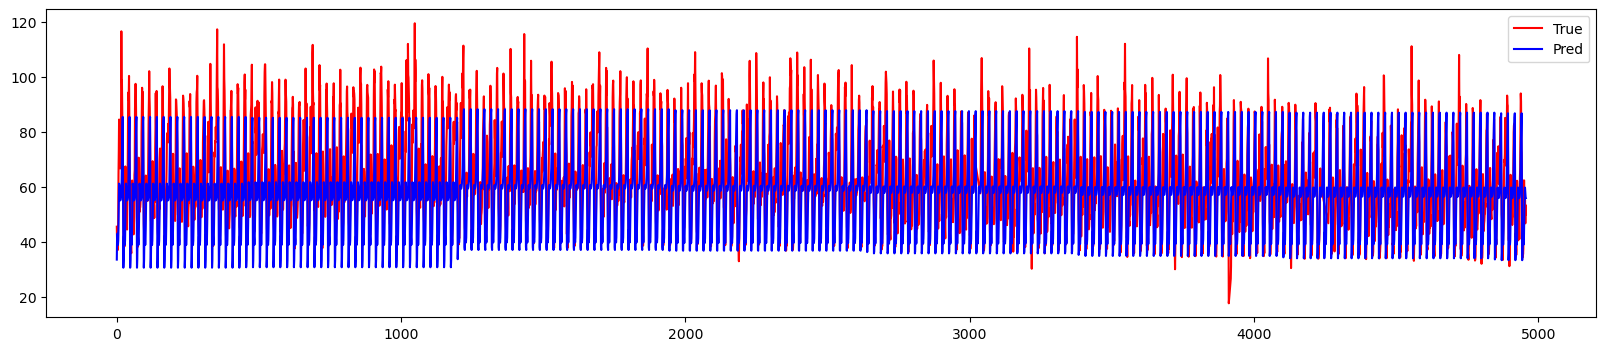

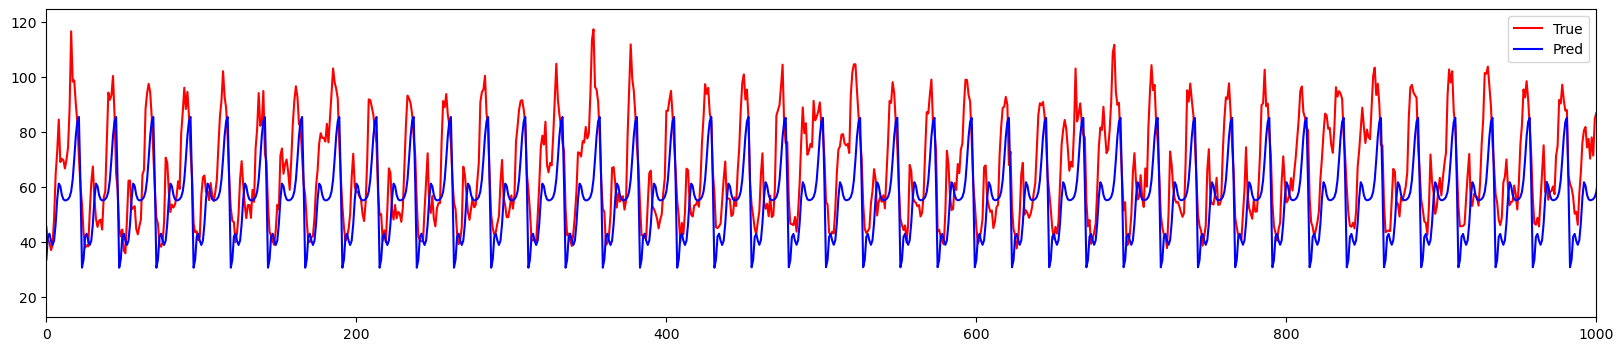

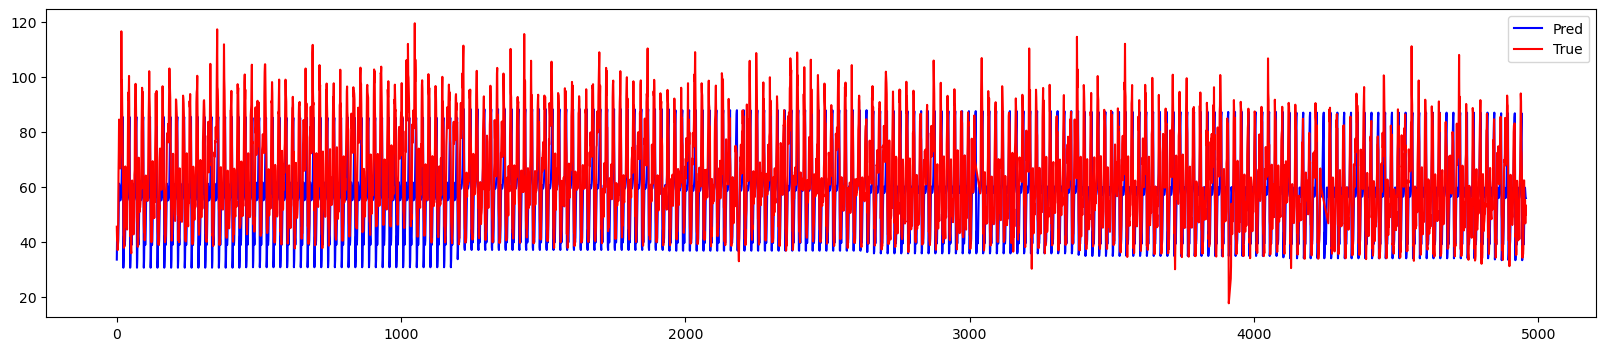

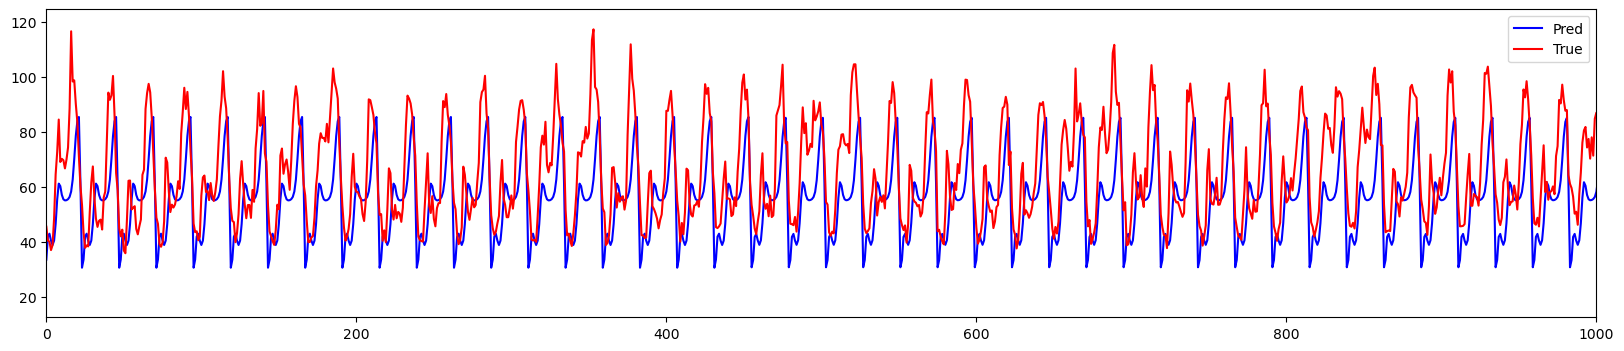

In [574]:
print(str_domain, ' /// ', str_interval, ' /// ', str_col_tar)

plt.figure(figsize=(20,4))
plt.plot(true, color='red', label='True')
plt.plot(pred, color='blue', label='Pred')
plt.legend()
plt.show()

plt.figure(figsize=(20,4))
plt.plot(true, color='red', label='True')
plt.plot(pred, color='blue', label='Pred')
plt.xlim(0, 1000)
plt.legend()
plt.show()

plt.figure(figsize=(20,4))
plt.plot(pred, color='blue', label='Pred')
plt.plot(true, color='red', label='True')
plt.legend()
plt.show()

plt.figure(figsize=(20,4))
plt.plot(pred, color='blue', label='Pred')
plt.plot(true, color='red', label='True')
plt.xlim(0, 1000)
plt.legend()
plt.show()